In [16]:
sql_script = f'''
SELECT ARRAY(SELECT DISTINCT payment_type FROM {PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME}) as payment_type_vocab,
       ARRAY(SELECT DISTINCT pickup_grid FROM {PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME}) as pickup_grid_vocab,
       ARRAY(SELECT DISTINCT dropoff_grid FROM {PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME}) as dropoff_grid_vocab,
       (SELECT AS STRUCT AVG(trip_seconds), VARIANCE(trip_seconds) FROM {PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME}) as trip_seconds_stats,
'''

training_data_stats = client.query(sql_script).result().to_dataframe()
training_data_stats.T

,0
payment_type_vocab,"[Cash, Prcard, Credit Card, Unknown, Mobile, D..."
pickup_grid_vocab,"[POINT(-87.6 41.8), POINT(-87.7 42), POINT(-87..."
dropoff_grid_vocab,"[POINT(-87.7 41.9), POINT(-87.7 42), POINT(-87..."
trip_seconds_stats,"{'_field_1': 873.2935509999938, '_field_2': 21..."


In [83]:
FEATURES = {
    "tip_bin": ("categorical", tf.int64),
    "trip_month": ("categorical", tf.int64),
    "trip_day": ("categorical", tf.int64),
    "trip_day_of_week": ("categorical", tf.int64),
    "trip_hour": ("categorical", tf.int64),
    "payment_type": ("categorical", tf.string),
    "pickup_grid": ("categorical", tf.string),
    "dropoff_grid": ("categorical", tf.string),
    "euclidean": ("numeric", tf.double),
    "trip_seconds": ("numeric", tf.int64),
    "trip_miles": ("numeric", tf.double),
}

TARGET_FEATURE_NAME = "tip_bin"

TARGET_LABELS = ["tip<20%", "tip>=20%"]

In [95]:
def get_bq_dataset(project_id, dataset_id, table_id, selected_fields, target_feature='tip_bin', batch_size=32):
    
    def _transform_row(row_dict):
        trimmed_dict = {column:
                       (tf.strings.strip(tensor) if tensor.dtype == 'string' else tensor) 
                       for (column,tensor) in row_dict.items()
                       }
        target = trimmed_dict.pop(target_feature)
        return (trimmed_dict, target)

    client = tfio_bq.BigQueryClient()
    parent = f'projects/{project_id}'

    read_session = client.read_session(
        parent=parent,
        project_id=project_id,
        table_id=table_id,
        dataset_id=dataset_id,
        selected_fields=selected_fields,
    )

    dataset = read_session.parallel_read_rows().map(_transform_row).batch(batch_size)
    
    return dataset


def get_category_encoding_layer(name, dataset, dtype):
    """Creates a CategoryEncoding layer for a given feature."""

    if dtype == tf.string:
      index = preprocessing.StringLookup()
    else:
      index = preprocessing.IntegerLookup()

    feature_ds = dataset.map(lambda x, y: x[name])
    index.adapt(feature_ds)
    encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

    return lambda feature: encoder(index(feature))


def get_normalization_layer(name, dataset):
  """"Creates a Normalization layer for a given feature."""
  normalizer = preprocessing.Normalization()

  feature_ds = dataset.map(lambda x, y: x[name])
  normalizer.adapt(feature_ds)

  return normalizer


def create_model(dataset, input_features, units, dropout_ratio):
    """Creates a binary classifier for Chicago Taxi tip prediction task."""
    
    all_inputs = []
    encoded_features = []
    for feature_name, feature_info in input_features.items():
        col = tf.keras.Input(shape=(1,), name=feature_name, dtype=feature_info[1])
        if feature_info[0] == 'categorical':
            
            encoding_layer = get_category_encoding_layer(feature_name, 
                                                         dataset,
                                                         feature_info[1])
        else:
            encoding_layer = get_normalization_layer(feature_name,
                                                     dataset) 
        encoded_col = encoding_layer(col)
        all_inputs.append(col)
        encoded_features.append(encoded_col)
        
    all_features = tf.keras.layers.concatenate(encoded_features)
    
    x = tf.keras.layers.Dense(units, activation="relu")(all_features)
    x = tf.keras.layers.Dropout(dropout_ratio)(x)
    output = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(all_inputs, output)
    
    return model
            

In [107]:
batch_size = 128

selected_fields = {key: {'output_type': value[1]} for key, value in FEATURES.items()}


validation_ds = get_bq_dataset(PROJECT, BQ_DATASET_NAME, 'validation_split', selected_fields, batch_size=batch_size)
training_ds = get_bq_dataset(PROJECT, BQ_DATASET_NAME, 'training_split', selected_fields, batch_size=batch_size)


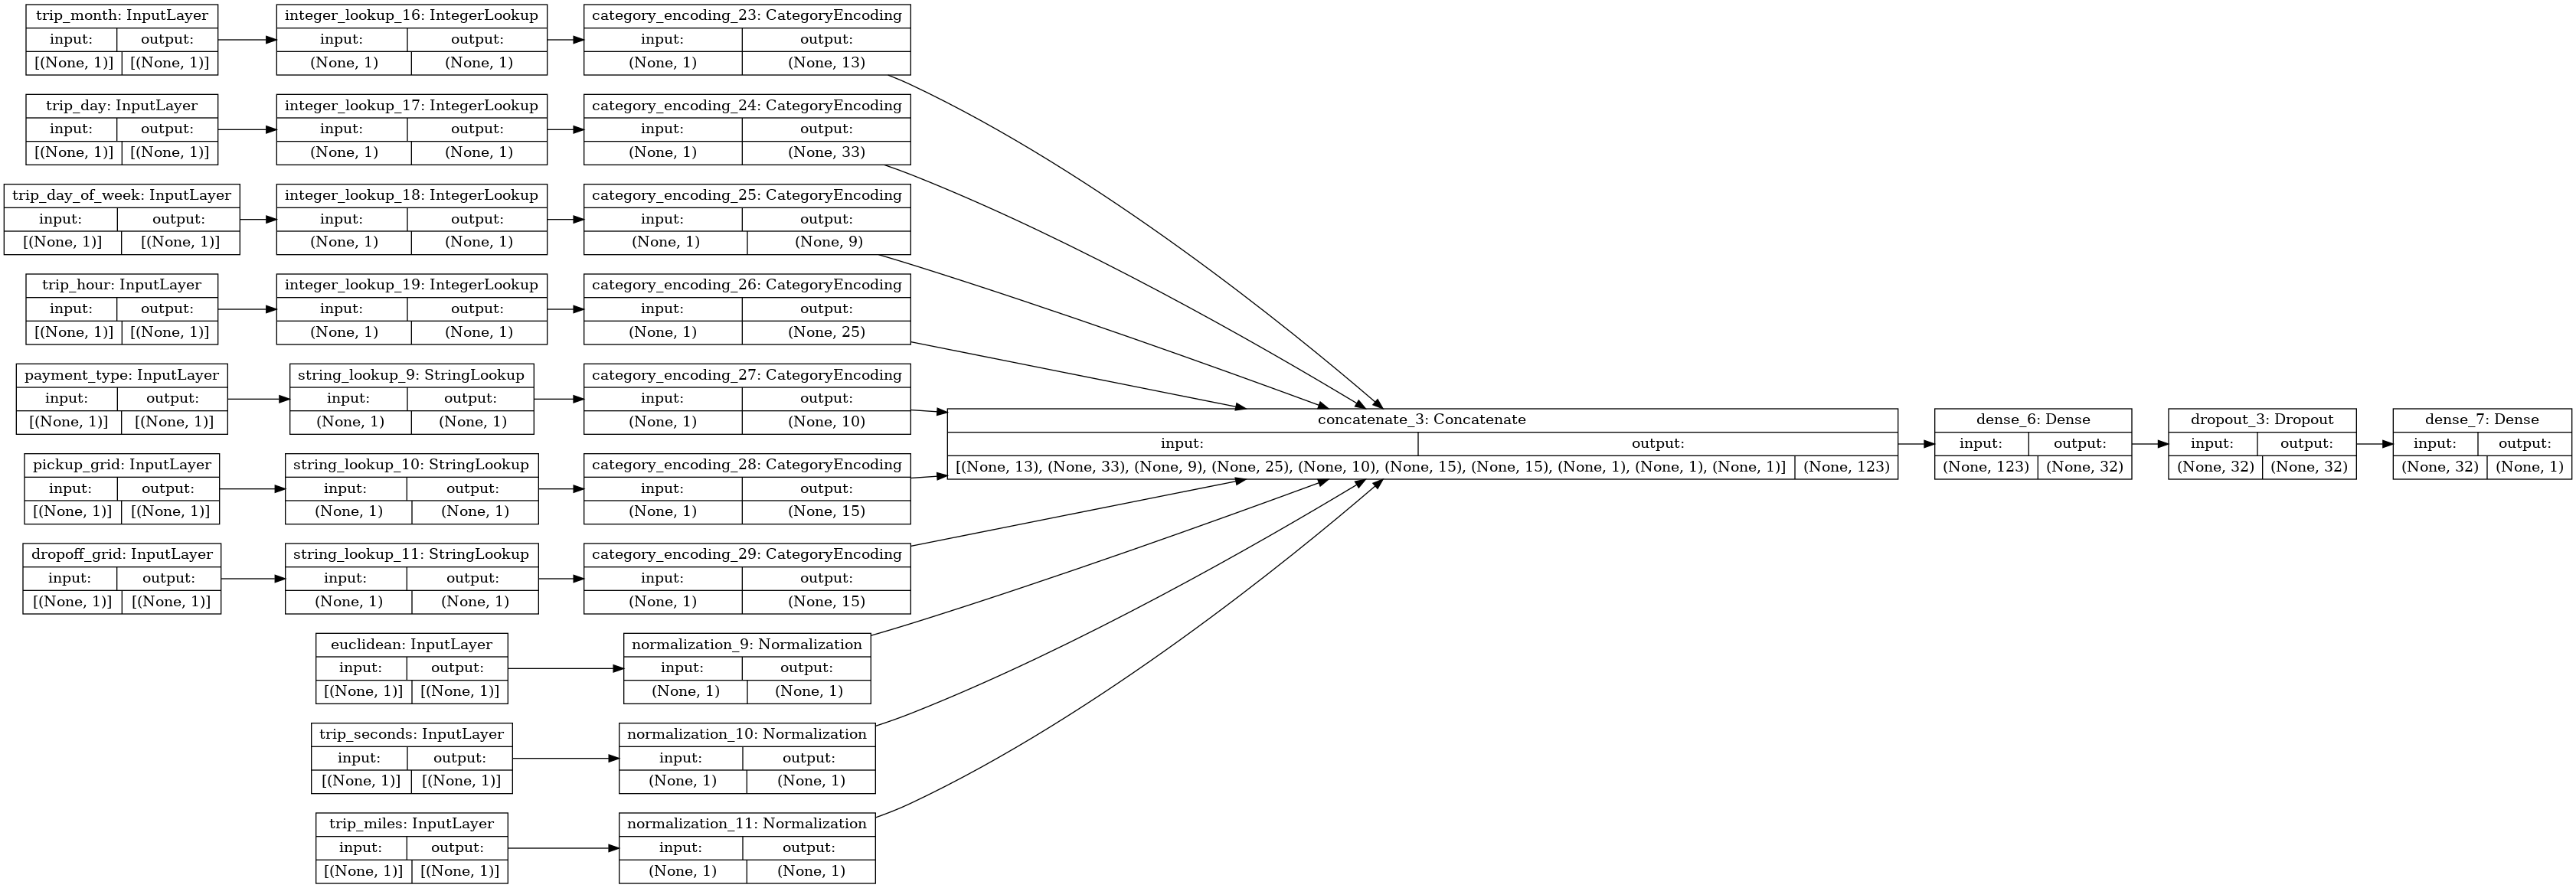

In [96]:
units = 32
dropout_ratio = 0.5

input_features = {key: value for key, value in FEATURES.items() if key != TARGET_FEATURE_NAME}

model = create_model(training_ds, input_features, units, dropout_ratio)

tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [108]:
optimizer = 'adam'
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = ['accuracy']

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [110]:
model.fit(training_ds, epochs=3, validation_data=validation_ds)

Epoch 1/3
5514/5514 [==============================] - 64s 11ms/step - loss: 0.2580 - accuracy: 0.8866 - val_loss: 0.2788 - val_accuracy: 0.8778
Epoch 2/3
5514/5514 [==============================] - 63s 11ms/step - loss: 0.2580 - accuracy: 0.8868 - val_loss: 0.2783 - val_accuracy: 0.8783
Epoch 3/3
5514/5514 [==============================] - 63s 11ms/step - loss: 0.2578 - accuracy: 0.8869 - val_loss: 0.2783 - val_accuracy: 0.8786


## Create a Vertex managed tabular dataset

In [ ]:
display_name = 'Chicago Taxi Tips'
filter = 'display_name="{}"'.format(display_name)

for dataset in vertex_ai.TabularDataset.list(filter=filter):
    print(dataset.display_name, ' : ', dataset.resource_name)

### List existing tabular datasets

### List existing tabular datasets

### Create a new tabular dataset based on the BigQuery table

In [ ]:
bq_source = f'bq://{PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME}'


dataset = vertex_ai.TabularDataset.create(
    display_name=display_name, bq_source=bq_source
)

In [1]:
import tensorflow_data_validation as tfdv

In [28]:
schema_file = 'gs://jk-vertex-workshop-bucket/schema/schema.pbtxt'

schema = tfdv.load_schema_text(
        input_path=schema_file
    )

In [20]:
from tensorflow_metadata.proto.v0 import schema_pb2, statistics_pb2, anomalies_pb2

In [21]:
tfdv.set_domain(schema, 
                'trip_hour', 
                schema_pb2.IntDomain(name='trip_hour', min=0, max=4, is_categorical=True))

2
4


In [22]:
tfdv.display_schema(schema=schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'trip_month',INT,required,,"[1,12]"
'trip_day',INT,required,,"[1,31]"
'trip_day_of_week',INT,required,,"[1,7]"
'trip_hour',INT,required,,"[0,4]"
'trip_seconds',INT,required,,-
'trip_miles',FLOAT,required,,-
'payment_type',STRING,required,,'payment_type'
'pickup_grid',STRING,required,,'pickup_grid'
'dropoff_grid',STRING,required,,'dropoff_grid'


In [23]:
stats_file = 'gs://jk-vertex-workshop-bucket/pipelines/895222332033/taxi-tip-predictor-continuous-training-20210608022816/generate-stats-op_3388501322759143424/stats/train/stats.pbtxt'

In [24]:
stats = tfdv.load_stats_text(
            input_path=stats_file)
        

In [25]:
tfdv.visualize_statistics(stats)

In [29]:
anomalies = tfdv.validate_statistics(statistics=stats, schema=schema)
tfdv.display_anomalies(anomalies)

/opt/conda/lib/python3.7/site-packages/tensorflow_data_validation/utils/display_util.py:188: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


In [31]:
if anomalies.anomaly_info:
    print('error')

In [13]:
anomaly_rows = []
for feature_name, anomaly_info in anomalies.anomaly_info.items():
    print(anomaly_info)

In [11]:
anomalies

baseline {
  feature {
    name: "trip_month"
    type: INT
    int_domain {
      name: "trip_month"
      min: 1
      max: 12
      is_categorical: true
    }
    presence {
      min_fraction: 1.0
      min_count: 1
    }
    shape {
      dim {
        size: 1
      }
    }
  }
  feature {
    name: "trip_day"
    type: INT
    int_domain {
      name: "trip_day"
      min: 1
      max: 31
      is_categorical: true
    }
    presence {
      min_fraction: 1.0
      min_count: 1
    }
    shape {
      dim {
        size: 1
      }
    }
  }
  feature {
    name: "trip_day_of_week"
    type: INT
    int_domain {
      name: "trip_day_of_week"
      min: 1
      max: 7
      is_categorical: true
    }
    presence {
      min_fraction: 1.0
      min_count: 1
    }
    shape {
      dim {
        size: 1
      }
    }
  }
  feature {
    name: "trip_hour"
    type: INT
    int_domain {
      name: "trip_hour"
      min: 0
      max: 23
      is_categorical: true
    }
    presence {

In [47]:
import tensorflow as tf
from tensorflow_io import bigquery as tfio_bq

In [48]:
model_path = model_path = 'gs://jk-vertex-workshop-bucket/pipelines/895222332033/taxi-tip-continuous-training-20210608050439/train-op_1857277449453174784/model'

In [64]:

model = tf.keras.models.load_model(model_path)

TypeError: __init__() got multiple values for keyword argument 'max_tokens'

In [57]:
def get_bq_dataset(table_name, selected_fields, target_feature='tip_bin', batch_size=32):
    
    def _transform_row(row_dict):
        trimmed_dict = {column:
                       (tf.strings.strip(tensor) if tensor.dtype == 'string' else tensor) 
                       for (column,tensor) in row_dict.items()
                       }
        target = trimmed_dict.pop(target_feature)
        return (trimmed_dict, target)

    project_id, dataset_id, table_id = table_name.split('.')
    
    client = tfio_bq.BigQueryClient()
    parent = f'projects/{project_id}'

    read_session = client.read_session(
        parent=parent,
        project_id=project_id,
        table_id=table_id,
        dataset_id=dataset_id,
        selected_fields=selected_fields,
    )

    dataset = read_session.parallel_read_rows().map(_transform_row).batch(batch_size)
    
    return dataset

In [58]:
FEATURES = {
    "tip_bin": ("categorical", tf.int64),
    "trip_month": ("categorical", tf.int64),
    "trip_day": ("categorical", tf.int64),
    "trip_day_of_week": ("categorical", tf.int64),
    "trip_hour": ("categorical", tf.int64),
    "payment_type": ("categorical", tf.string),
    "pickup_grid": ("categorical", tf.string),
    "dropoff_grid": ("categorical", tf.string),
    "euclidean": ("numeric", tf.double),
    "trip_seconds": ("numeric", tf.int64),
    "trip_miles": ("numeric", tf.double),
}

TARGET_FEATURE_NAME = "tip_bin"
TARGET_LABELS = ["tip<20%", "tip>=20%"]

In [59]:
selected_fields = {key: {'output_type': value[1]} for key, value in FEATURES.items()}

In [60]:
testing_ds = get_bq_dataset('jk-mlops-dev.chicago_taxi_ml.testing',
                                selected_fields,
                                batch_size=32)

In [61]:
model.evaluate(testing_ds)

AttributeError: '_UserObject' object has no attribute 'evaluate'